In [5]:
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
from pathlib import Path

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Models
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    VotingClassifier, GradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering

# Metrics
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, auc,
    mean_absolute_error, mean_squared_error, r2_score,
    silhouette_score, silhouette_samples
)

# Clustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [6]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

In [7]:
CONFIG = {
    'random_state': 42,
    'test_size': 0.2,
    'cv_folds': 5,
    'time_required': 45, 
    'num_pred_columns': 15,
    'verbose': True
}

In [8]:
# UTILITY FUNCTIONS

class PerformanceTracker:
    """Track and compare model performances"""
    def __init__(self):
        self.results = []
    
    def add_result(self, model_name, task_type, metrics):
        """Add model results"""
        self.results.append({
            'model': model_name,
            'task': task_type,
            'timestamp': datetime.now().isoformat(),
            **metrics
        })
    
    def get_dataframe(self):
        """Get results as DataFrame"""
        return pd.DataFrame(self.results)
    
    def get_best_model(self, task_type, metric='accuracy'):
        """Get best performing model for task"""
        df = self.get_dataframe()
        task_df = df[df['task'] == task_type]
        if len(task_df) == 0:
            return None, None
        best_idx = task_df[metric].idxmax()
        best_row = task_df.loc[best_idx]
        return best_row['model'], best_row.to_dict()

tracker = PerformanceTracker()

# Dataset Creation

In [9]:
order_details = pd.read_csv("order_details.csv")
orders = pd.read_csv("orders.csv")
pizza_types = pd.read_csv("pizza_types.csv", encoding='latin1')
pizzas = pd.read_csv("pizzas.csv")

In [10]:
df = order_details.merge(pizzas, on='pizza_id', how='left')
df = df.merge(pizza_types, on='pizza_type_id', how='left')
df = df.merge(orders, on='order_id', how='left')
df.head()

,order_details_id,order_id,pizza_id,quantity,pizza_type_id,size,price,name,category,ingredients,date,time
0,1,1,hawaiian_m,1,hawaiian,M,13.2500,The Hawaiian Pizza,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",2015-01-01,11:38:36
1,2,2,classic_dlx_m,1,classic_dlx,M,16.0000,The Classic Deluxe Pizza,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",2015-01-01,11:57:40
2,3,2,five_cheese_l,1,five_cheese,L,18.5000,The Five Cheese Pizza,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",2015-01-01,11:57:40
3,4,2,ital_supr_l,1,ital_supr,L,20.7500,The Italian Supreme Pizza,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",2015-01-01,11:57:40
4,5,2,mexicana_m,1,mexicana,M,16.0000,The Mexicana Pizza,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",2015-01-01,11:57:40


In [11]:
df['datetime'] = df['date'] + " " + df["time"]
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date
df['day_of_week'] = df['datetime'].dt.day_name()
df['time'] = df['datetime'].dt.time

In [12]:
ingredients_dummies = df['ingredients'].str.get_dummies(sep=', ')
ingredients_dummies = ingredients_dummies.rename(columns = {"\x91Nduja Salami": "Nduja Salami"})
df = pd.concat([df, ingredients_dummies], axis=1)
df.head()

,order_details_id,order_id,pizza_id,quantity,pizza_type_id,size,price,name,category,ingredients,date,time,datetime,day_of_week,Alfredo Sauce,Anchovies,Artichoke,Artichokes,Arugula,Asiago Cheese,Bacon,Barbecue Sauce,Barbecued Chicken,Beef Chuck Roast,Blue Cheese,Brie Carre Cheese,Calabrese Salami,Capocollo,Caramelized Onions,Chicken,Chipotle Sauce,Chorizo Sausage,Cilantro,Coarse Sicilian Salami,Corn,Eggplant,Feta Cheese,Fontina Cheese,Friggitello Peppers,Garlic,Genoa Salami,Goat Cheese,Gorgonzola Piccante Cheese,Gouda Cheese,Green Olives,Green Peppers,Italian Sausage,Jalapeno Peppers,Kalamata Olives,Luganega Sausage,Mozzarella Cheese,Mushrooms,Onions,Oregano,Pancetta,Parmigiano Reggiano Cheese,Pears,Peperoncini verdi,Pepperoni,Pesto Sauce,Pineapple,Plum Tomatoes,Prosciutto,Prosciutto di San Daniele,Provolone Cheese,Red Onions,Red Peppers,Ricotta Cheese,Romano Cheese,Sliced Ham,Smoked Gouda Cheese,Soppressata Salami,Spinach,Sun-dried Tomatoes,Thai Sweet Chilli Sauce,Thyme,Tomatoes,Zucchini,Nduja Salami
0,1,1,hawaiian_m,1,hawaiian,M,13.2500,The Hawaiian Pizza,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",2015-01-01,11:38:36,2015-01-01 11:38:36,Thursday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2,2,classic_dlx_m,1,classic_dlx,M,16.0000,The Classic Deluxe Pizza,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",2015-01-01,11:57:40,2015-01-01 11:57:40,Thursday,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,3,2,five_cheese_l,1,five_cheese,L,18.5000,The Five Cheese Pizza,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",2015-01-01,11:57:40,2015-01-01 11:57:40,Thursday,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0
3,4,2,ital_supr_l,1,ital_supr,L,20.7500,The Italian Supreme Pizza,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",2015-01-01,11:57:40,2015-01-01 11:57:40,Thursday,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,5,2,mexicana_m,1,mexicana,M,16.0000,The Mexicana Pizza,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",2015-01-01,11:57:40,2015-01-01 11:57:40,Thursday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0


In [13]:
df['total_order_price'] = df['price'] * df['quantity']
df['total_order_price_total'] = df.groupby('order_id')['total_order_price'].transform('sum')

cols_to_drop = ['order_details_id', 'pizza_id', 'datetime', 'ingredients']
df = df.drop(columns=cols_to_drop)

base_cols = ['order_id', 'quantity', 'pizza_type_id', 'size', 'price', 'name', 'category', 'date', 'day_of_week', 'time']
ingredient_cols = sorted(ingredients_dummies.columns.tolist())
price_cols = ['total_order_price_total']

pizza_final_df = df[base_cols + ingredient_cols + price_cols]

pizza_final_df['date'] = pd.to_datetime(pizza_final_df['date']).dt.date
pizza_final_df['hour'] = pd.to_datetime(pizza_final_df['time'], format='%H:%M:%S').dt.hour
pizza_final_df['day_of_week_num'] = pd.to_datetime(pizza_final_df['date']).dt.dayofweek
pizza_final_df['order_quantity_total'] = pizza_final_df.groupby('order_id')['quantity'].transform('sum')

pizza_final_df.head()

,order_id,quantity,pizza_type_id,size,price,name,category,date,day_of_week,time,Alfredo Sauce,Anchovies,Artichoke,Artichokes,Arugula,Asiago Cheese,Bacon,Barbecue Sauce,Barbecued Chicken,Beef Chuck Roast,Blue Cheese,Brie Carre Cheese,Calabrese Salami,Capocollo,Caramelized Onions,Chicken,Chipotle Sauce,Chorizo Sausage,Cilantro,Coarse Sicilian Salami,Corn,Eggplant,Feta Cheese,Fontina Cheese,Friggitello Peppers,Garlic,Genoa Salami,Goat Cheese,Gorgonzola Piccante Cheese,Gouda Cheese,Green Olives,Green Peppers,Italian Sausage,Jalapeno Peppers,Kalamata Olives,Luganega Sausage,Mozzarella Cheese,Mushrooms,Nduja Salami,Onions,Oregano,Pancetta,Parmigiano Reggiano Cheese,Pears,Peperoncini verdi,Pepperoni,Pesto Sauce,Pineapple,Plum Tomatoes,Prosciutto,Prosciutto di San Daniele,Provolone Cheese,Red Onions,Red Peppers,Ricotta Cheese,Romano Cheese,Sliced Ham,Smoked Gouda Cheese,Soppressata Salami,Spinach,Sun-dried Tomatoes,Thai Sweet Chilli Sauce,Thyme,Tomatoes,Zucchini,total_order_price_total,hour,day_of_week_num,order_quantity_total
0,1,1,hawaiian,M,13.2500,The Hawaiian Pizza,Classic,2015-01-01,Thursday,11:38:36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,13.2500,11,3,1
1,2,1,classic_dlx,M,16.0000,The Classic Deluxe Pizza,Classic,2015-01-01,Thursday,11:57:40,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,92.0000,11,3,5
2,2,1,five_cheese,L,18.5000,The Five Cheese Pizza,Veggie,2015-01-01,Thursday,11:57:40,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,92.0000,11,3,5
3,2,1,ital_supr,L,20.7500,The Italian Supreme Pizza,Supreme,2015-01-01,Thursday,11:57:40,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,92.0000,11,3,5
4,2,1,mexicana,M,16.0000,The Mexicana Pizza,Veggie,2015-01-01,Thursday,11:57:40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,92.0000,11,3,5


In [14]:
trends_map = {
    'Chicken': 'Chicken pizza google trends 2015.csv',
    'Classic': 'Classic pizza google trends 2015.csv',
    'Veggie': 'Veggie pizza google trends 2015.csv',
    'Supreme': 'Supreme pizza google trends 2015.csv'
}

trends_list = []
for cat, file in trends_map.items():
    t_df = pd.read_csv(file, skiprows=2)
    t_df.columns = ['Week', 'google_trends_score']
    t_df['category'] = cat
    t_df['Week'] = pd.to_datetime(t_df['Week'])
    trends_list.append(t_df)

all_trends = pd.concat(trends_list)
all_trends

,Week,google_trends_score,category
0,2014-12-28,87,Chicken
1,2015-01-04,84,Chicken
2,2015-01-11,82,Chicken
3,2015-01-18,85,Chicken
4,2015-01-25,88,Chicken
...,...,...,...
48,2015-11-29,80,Supreme
49,2015-12-06,73,Supreme
50,2015-12-13,91,Supreme
51,2015-12-20,78,Supreme


In [15]:
weather_url = "https://raw.githubusercontent.com/leokassio/weather-underground-data/master/new-york-2015.csv"
weather_df = pd.read_csv(weather_url)

weather_df.head()

,EST,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,2015-1-1,4,1,-3,-8,-12,-14,46,37,27,1022.0000,1018.0000,1015.0000,16.0000,16.0000,16.0000,27.0000,11.0000,50.0000,0.00,0.0000,NaN,254
1,2015-1-2,6,4,2,-7,-8,-9,52,43,33,1031.0000,1023.0000,1016.0000,16.0000,16.0000,16.0000,24.0000,11.0000,40.0000,0.00,1.0000,NaN,278
2,2015-1-3,6,3,1,4,-2,-9,92,68,44,1036.0000,1030.0000,1019.0000,16.0000,7.0000,1.0000,19.0000,10.0000,29.0000,18.03,6.0000,Rain-Snow,75
3,2015-1-4,13,9,5,10,6,-3,93,88,83,1019.0000,1012.0000,1004.0000,16.0000,9.0000,1.0000,47.0000,10.0000,74.0000,7.62,7.0000,Rain,274
4,2015-1-5,9,2,-6,-3,-12,-19,49,38,26,1030.0000,1020.0000,1009.0000,16.0000,16.0000,16.0000,39.0000,17.0000,61.0000,0.00,2.0000,NaN,291


In [16]:
weather_df.columns = weather_df.columns.str.strip()
weather_df['date'] = pd.to_datetime(weather_df['EST']).dt.date
weather_df['Events'] = weather_df['Events'].fillna('Sunny')

In [17]:
data = pizza_final_df.copy()

data['date_dt'] = pd.to_datetime(data['date'])
data['Week'] = data['date_dt'] - pd.to_timedelta((data['date_dt'].dt.dayofweek + 1) % 7, unit='d')

data = data.merge(all_trends, on=['Week', 'category'], how='left')

data = data.merge(
    weather_df, 
    how='left', 
    on='date'
)

In [18]:
data.drop(columns=['date_dt', 'Week'], inplace=True)
data.head()

,order_id,quantity,pizza_type_id,size,price,name,category,date,day_of_week,time,Alfredo Sauce,Anchovies,Artichoke,Artichokes,Arugula,Asiago Cheese,Bacon,Barbecue Sauce,Barbecued Chicken,Beef Chuck Roast,Blue Cheese,Brie Carre Cheese,Calabrese Salami,Capocollo,Caramelized Onions,Chicken,Chipotle Sauce,Chorizo Sausage,Cilantro,Coarse Sicilian Salami,Corn,Eggplant,Feta Cheese,Fontina Cheese,Friggitello Peppers,Garlic,Genoa Salami,Goat Cheese,Gorgonzola Piccante Cheese,Gouda Cheese,Green Olives,Green Peppers,Italian Sausage,Jalapeno Peppers,Kalamata Olives,Luganega Sausage,Mozzarella Cheese,Mushrooms,Nduja Salami,Onions,Oregano,Pancetta,Parmigiano Reggiano Cheese,Pears,Peperoncini verdi,Pepperoni,Pesto Sauce,Pineapple,Plum Tomatoes,Prosciutto,Prosciutto di San Daniele,Provolone Cheese,Red Onions,Red Peppers,Ricotta Cheese,Romano Cheese,Sliced Ham,Smoked Gouda Cheese,Soppressata Salami,Spinach,Sun-dried Tomatoes,Thai Sweet Chilli Sauce,Thyme,Tomatoes,Zucchini,total_order_price_total,hour,day_of_week_num,order_quantity_total,google_trends_score,EST,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,1,1,hawaiian,M,13.2500,The Hawaiian Pizza,Classic,2015-01-01,Thursday,11:38:36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,13.2500,11,3,1,100,2015-1-1,4,1,-3,-8,-12,-14,46,37,27,1022.0000,1018.0000,1015.0000,16.0000,16.0000,16.0000,27.0000,11.0000,50.0000,0.00,0.0000,Sunny,254
1,2,1,classic_dlx,M,16.0000,The Classic Deluxe Pizza,Classic,2015-01-01,Thursday,11:57:40,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,92.0000,11,3,5,100,2015-1-1,4,1,-3,-8,-12,-14,46,37,27,1022.0000,1018.0000,1015.0000,16.0000,16.0000,16.0000,27.0000,11.0000,50.0000,0.00,0.0000,Sunny,254
2,2,1,five_cheese,L,18.5000,The Five Cheese Pizza,Veggie,2015-01-01,Thursday,11:57:40,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,92.0000,11,3,5,77,2015-1-1,4,1,-3,-8,-12,-14,46,37,27,1022.0000,1018.0000,1015.0000,16.0000,16.0000,16.0000,27.0000,11.0000,50.0000,0.00,0.0000,Sunny,254
3,2,1,ital_supr,L,20.7500,The Italian Supreme Pizza,Supreme,2015-01-01,Thursday,11:57:40,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,92.0000,11,3,5,81,2015-1-1,4,1,-3,-8,-12,-14,46,37,27,1022.0000,1018.0000,1015.0000,16.0000,16.0000,16.0000,27.0000,11.0000,50.0000,0.00,0.0000,Sunny,254
4,2,1,mexicana,M,16.0000,The Mexicana Pizza,Veggie,2015-01-01,Thursday,11:57:40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,92.0000,11,3,5,77,2015-1-1,4,1,-3,-8,-12,-14,46,37,27,1022.0000,1018.0000,1015.0000,16.0000,16.0000,16.0000,27.0000,11.0000,50.0000,0.00,0.0000,Sunny,254


In [19]:
data['date'] = pd.to_datetime(data['date'])

season_mapping = {
    1: 'Winter', 2: 'Winter', 12: 'Winter', 11: 'Winter', 
    3: 'Spring', 4: 'Spring', 
    5: 'Summer', 6: 'Summer', 7: 'Summer', 
    8: 'Fall', 9: 'Fall', 10: 'Fall'
}

data['Season'] = data['date'].dt.month.map(season_mapping)
data.head()

,order_id,quantity,pizza_type_id,size,price,name,category,date,day_of_week,time,Alfredo Sauce,Anchovies,Artichoke,Artichokes,Arugula,Asiago Cheese,Bacon,Barbecue Sauce,Barbecued Chicken,Beef Chuck Roast,Blue Cheese,Brie Carre Cheese,Calabrese Salami,Capocollo,Caramelized Onions,Chicken,Chipotle Sauce,Chorizo Sausage,Cilantro,Coarse Sicilian Salami,Corn,Eggplant,Feta Cheese,Fontina Cheese,Friggitello Peppers,Garlic,Genoa Salami,Goat Cheese,Gorgonzola Piccante Cheese,Gouda Cheese,Green Olives,Green Peppers,Italian Sausage,Jalapeno Peppers,Kalamata Olives,Luganega Sausage,Mozzarella Cheese,Mushrooms,Nduja Salami,Onions,Oregano,Pancetta,Parmigiano Reggiano Cheese,Pears,Peperoncini verdi,Pepperoni,Pesto Sauce,Pineapple,Plum Tomatoes,Prosciutto,Prosciutto di San Daniele,Provolone Cheese,Red Onions,Red Peppers,Ricotta Cheese,Romano Cheese,Sliced Ham,Smoked Gouda Cheese,Soppressata Salami,Spinach,Sun-dried Tomatoes,Thai Sweet Chilli Sauce,Thyme,Tomatoes,Zucchini,total_order_price_total,hour,day_of_week_num,order_quantity_total,google_trends_score,EST,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,Season
0,1,1,hawaiian,M,13.2500,The Hawaiian Pizza,Classic,2015-01-01,Thursday,11:38:36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,13.2500,11,3,1,100,2015-1-1,4,1,-3,-8,-12,-14,46,37,27,1022.0000,1018.0000,1015.0000,16.0000,16.0000,16.0000,27.0000,11.0000,50.0000,0.00,0.0000,Sunny,254,Winter
1,2,1,classic_dlx,M,16.0000,The Classic Deluxe Pizza,Classic,2015-01-01,Thursday,11:57:40,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,92.0000,11,3,5,100,2015-1-1,4,1,-3,-8,-12,-14,46,37,27,1022.0000,1018.0000,1015.0000,16.0000,16.0000,16.0000,27.0000,11.0000,50.0000,0.00,0.0000,Sunny,254,Winter
2,2,1,five_cheese,L,18.5000,The Five Cheese Pizza,Veggie,2015-01-01,Thursday,11:57:40,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,92.0000,11,3,5,77,2015-1-1,4,1,-3,-8,-12,-14,46,37,27,1022.0000,1018.0000,1015.0000,16.0000,16.0000,16.0000,27.0000,11.0000,50.0000,0.00,0.0000,Sunny,254,Winter
3,2,1,ital_supr,L,20.7500,The Italian Supreme Pizza,Supreme,2015-01-01,Thursday,11:57:40,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,92.0000,11,3,5,81,2015-1-1,4,1,-3,-8,-12,-14,46,37,27,1022.0000,1018.0000,1015.0000,16.0000,16.0000,16.0000,27.0000,11.0000,50.0000,0.00,0.0000,Sunny,254,Winter
4,2,1,mexicana,M,16.0000,The Mexicana Pizza,Veggie,2015-01-01,Thursday,11:57:40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,92.0000,11,3,5,77,2015-1-1,4,1,-3,-8,-12,-14,46,37,27,1022.0000,1018.0000,1015.0000,16.0000,16.0000,16.0000,27.0000,11.0000,50.0000,0.00,0.0000,Sunny,254,Winter


In [20]:
data.columns.tolist()

['order_id',
 'quantity',
 'pizza_type_id',
 'size',
 'price',
 'name',
 'category',
 'date',
 'day_of_week',
 'time',
 'Alfredo Sauce',
 'Anchovies',
 'Artichoke',
 'Artichokes',
 'Arugula',
 'Asiago Cheese',
 'Bacon',
 'Barbecue Sauce',
 'Barbecued Chicken',
 'Beef Chuck Roast',
 'Blue Cheese',
 'Brie Carre Cheese',
 'Calabrese Salami',
 'Capocollo',
 'Caramelized Onions',
 'Chicken',
 'Chipotle Sauce',
 'Chorizo Sausage',
 'Cilantro',
 'Coarse Sicilian Salami',
 'Corn',
 'Eggplant',
 'Feta Cheese',
 'Fontina Cheese',
 'Friggitello Peppers',
 'Garlic',
 'Genoa Salami',
 'Goat Cheese',
 'Gorgonzola Piccante Cheese',
 'Gouda Cheese',
 'Green Olives',
 'Green Peppers',
 'Italian Sausage',
 'Jalapeno Peppers',
 'Kalamata Olives',
 'Luganega Sausage',
 'Mozzarella Cheese',
 'Mushrooms',
 'Nduja Salami',
 'Onions',
 'Oregano',
 'Pancetta',
 'Parmigiano Reggiano Cheese',
 'Pears',
 'Peperoncini verdi',
 'Pepperoni',
 'Pesto Sauce',
 'Pineapple',
 'Plum Tomatoes',
 'Prosciutto',
 'Prosciutto

# EDA

In [23]:
print(f"\nDate range: {data['date'].min()} to {data['date'].max()}")
print(f"Total orders: {data['order_id'].nunique():,}")
print(f"Total items sold: {data['quantity'].sum():,}")
print(f"Total revenue: ${data['total_order_price_total'].sum():,.2f}")


Date range: 2015-01-01 00:00:00 to 2015-12-31 00:00:00
Total orders: 21,350
Total items sold: 49,574
Total revenue: $2,951,196.95


In [25]:
daily_stats = data.groupby('date').agg({
    'order_id': 'nunique',
    'quantity': 'sum',
    'total_order_price_total': 'sum'
}).rename(columns={
    'order_id': 'orders',
    'quantity': 'items',
    'total_order_price_total': 'revenue'
})

print(f"\nDaily Statistics:")
print(f"  Average orders/day: {daily_stats['orders'].mean():.0f}")
print(f"  Average items/day: {daily_stats['items'].mean():.0f}")
print(f"  Average revenue/day: ${daily_stats['revenue'].mean():,.2f}")


Daily Statistics:
  Average orders/day: 60
  Average items/day: 138
  Average revenue/day: $8,243.57


In [26]:
peak_day = daily_stats['orders'].idxmax()
peak_orders = daily_stats.loc[peak_day, 'orders']
peak_items = daily_stats.loc[peak_day, 'items']

print(f"\nPeak day: {peak_day}")
print(f"  Orders: {peak_orders}")
print(f"  Items: {peak_items}")
print(f"  Revenue: ${daily_stats.loc[peak_day, 'revenue']:,.2f}")


Peak day: 2015-11-27 00:00:00
  Orders: 115
  Items: 264
  Revenue: $13,984.85


In [28]:
category_dist = data.groupby('category').agg({
    'quantity': 'sum',
    'total_order_price_total': 'sum'
}).sort_values('quantity', ascending=False)

print("\nCategory Distribution:\n")
print(category_dist.to_string())

size_dist = data.groupby('size').agg({
    'quantity': 'sum',
    'total_order_price_total': 'sum'
}).sort_values('quantity', ascending=False)



Category Distribution:

          quantity  total_order_price_total
category                                   
Classic      14888              854962.1500
Supreme      11987              730640.8500
Veggie       11649              697016.9500
Chicken      11050              668577.0000


In [30]:
dow_stats = data.groupby('day_of_week').agg({
    'order_id': 'nunique',
    'quantity': 'sum'
}).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

print("\nOrders by Day of Week:\n")
print(dow_stats.to_string())


Orders by Day of Week:

             order_id  quantity
day_of_week                    
Monday           2794      6485
Tuesday          2973      6895
Wednesday        3024      6946
Thursday         3239      7478
Friday           3538      8242
Saturday         3158      7493
Sunday           2624      6035


In [31]:
hour_stats = data.groupby('hour').agg({
    'order_id': 'nunique',
    'quantity': 'sum'
}).sort_values('order_id', ascending=False)

print("\nTop 5 Hours by Order Volume:\n")
print(hour_stats.head().to_string())


Top 5 Hours by Order Volume:

      order_id  quantity
hour                    
12        2520      6776
13        2455      6413
18        2399      5417
17        2336      5211
19        2009      4406


In [32]:
weather_stats = data.groupby('Events').agg({
    'order_id': 'nunique',
    'quantity': 'sum'
}).sort_values('order_id', ascending=False)

print("\nOrders by Weather Condition:\n")
print(weather_stats.to_string())


Orders by Weather Condition:

               order_id  quantity
Events                           
Sunny             14625     34143
Rain               4442     10290
Snow                870      1948
Fog-Rain            775      1733
Fog-Rain-Snow       246       556
Fog-Snow            236       512
Rain-Snow           156       392


# Preparing Seating Data

In [33]:
time_required = CONFIG['time_required']

seating_df = data.groupby(['order_id', 'date', 'time']).quantity.sum().reset_index(
    name='Number_of_people_seated'
).set_index('order_id')

seating_df['start_time'] = pd.to_datetime(
    seating_df['date'].astype(str) + ' ' + seating_df['time'].astype(str)
)
seating_df['end_time'] = seating_df['start_time'] + pd.Timedelta(minutes=time_required)
seating_df['date'] = pd.to_datetime(seating_df['date']).dt.strftime('%Y-%m-%d')

seating_df = seating_df[seating_df.Number_of_people_seated.isin(np.arange(1, 16))]
seating_df.drop(columns=['time'], inplace=True)

print(f"\nSeating dataset created: {len(seating_df):,} seating events")
print(f"Date range: {seating_df['date'].min()} to {seating_df['date'].max()}")


Seating dataset created: 21,348 seating events
Date range: 2015-01-01 to 2015-12-31


In [35]:
seating_df.head()

,date,Number_of_people_seated,start_time,end_time
order_id,,,,
1,2015-01-01,1,2015-01-01 11:38:36,2015-01-01 12:23:36
2,2015-01-01,5,2015-01-01 11:57:40,2015-01-01 12:42:40
3,2015-01-01,2,2015-01-01 12:12:28,2015-01-01 12:57:28
4,2015-01-01,1,2015-01-01 12:16:31,2015-01-01 13:01:31
5,2015-01-01,1,2015-01-01 12:21:30,2015-01-01 13:06:30


In [34]:
group_dist = seating_df['Number_of_people_seated'].value_counts().sort_index()
print("\nGroup Size Distribution:")
for size, count in group_dist.items():
    pct = 100 * count / len(seating_df)
    print(f"  {size} people: {count:,} ({pct:.1f}%)")


Group Size Distribution:
  1 people: 8,111 (38.0%)
  2 people: 6,152 (28.8%)
  3 people: 3,207 (15.0%)
  4 people: 3,122 (14.6%)
  5 people: 145 (0.7%)
  6 people: 80 (0.4%)
  7 people: 61 (0.3%)
  8 people: 67 (0.3%)
  9 people: 64 (0.3%)
  10 people: 56 (0.3%)
  11 people: 56 (0.3%)
  12 people: 54 (0.3%)
  13 people: 50 (0.2%)
  14 people: 66 (0.3%)
  15 people: 57 (0.3%)


November 26, 2015, marks the highest recorded activity in the dataset with a total order quantity of 266

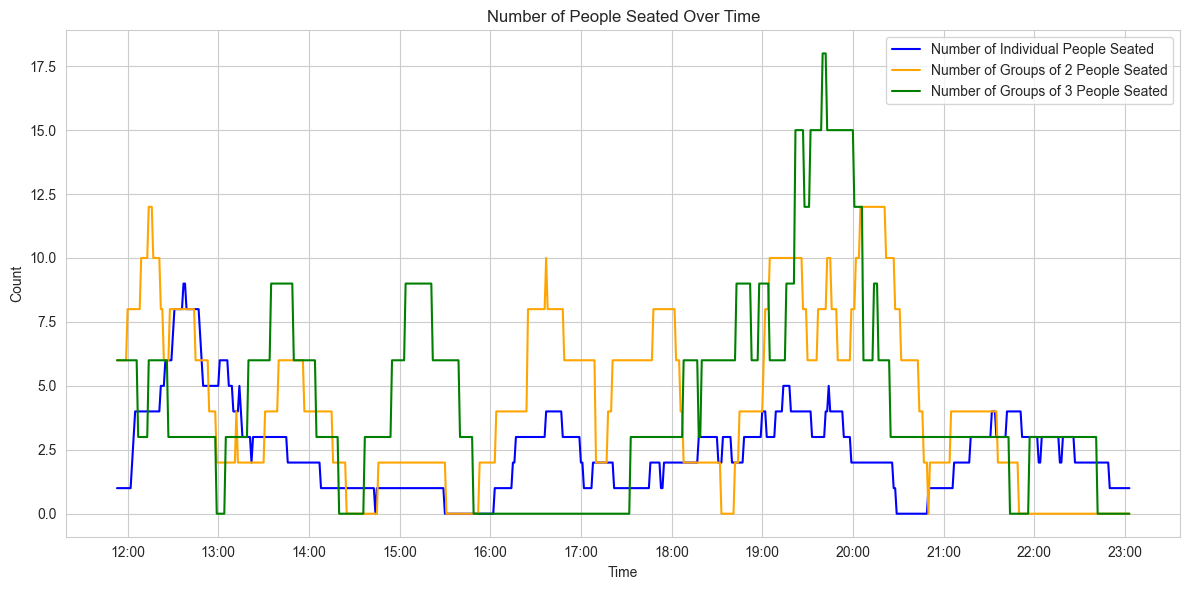

In [37]:
warnings.filterwarnings("ignore")
chosen_day = '2015-11-26'

filtered_df_1 = seating_df[(seating_df['date'] == chosen_day) & (seating_df['Number_of_people_seated'] == 1)]
filtered_df_2 = seating_df[(seating_df['date'] == chosen_day) & (seating_df['Number_of_people_seated'] == 2)]
filtered_df_3 = seating_df[(seating_df['date'] == chosen_day) & (seating_df['Number_of_people_seated'] == 3)]

for filtered_df in [filtered_df_1, filtered_df_2, filtered_df_3]:
    filtered_df["start_time"] = pd.to_datetime(filtered_df["start_time"])
    filtered_df["end_time"] = pd.to_datetime(filtered_df["end_time"])

min_time = filtered_df_1["start_time"].min()
max_time = filtered_df_1["end_time"].max()
time_range = pd.date_range(start=min_time, end=max_time, freq='T')

time_counts_1 = pd.DataFrame({"time": time_range, "count": 0})
time_counts_2 = pd.DataFrame({"time": time_range, "count": 0})
time_counts_3 = pd.DataFrame({"time": time_range, "count": 0})

for _, row in filtered_df_1.iterrows():
    mask = (time_counts_1["time"] >= row["start_time"]) & (time_counts_1["time"] <= row["end_time"])
    time_counts_1.loc[mask, "count"] += row["Number_of_people_seated"]

for _, row in filtered_df_2.iterrows():
    mask = (time_counts_2["time"] >= row["start_time"]) & (time_counts_2["time"] <= row["end_time"])
    time_counts_2.loc[mask, "count"] += row["Number_of_people_seated"]

for _, row in filtered_df_3.iterrows():
    mask = (time_counts_3["time"] >= row["start_time"]) & (time_counts_3["time"] <= row["end_time"])
    time_counts_3.loc[mask, "count"] += row["Number_of_people_seated"]

plt.figure(figsize=(12, 6))
plt.plot(time_counts_1["time"], time_counts_1["count"], label="Number of Individual People Seated", color="blue")
plt.plot(time_counts_2["time"], time_counts_2["count"], label="Number of Groups of 2 People Seated", color="orange")
plt.plot(time_counts_3["time"], time_counts_3["count"], label="Number of Groups of 3 People Seated", color="green")

hourly_ticks = time_counts_1["time"][time_counts_1["time"].dt.minute == 0]
plt.xticks(
    hourly_ticks,  
    hourly_ticks.dt.strftime('%H:%M'), 
)
plt.title("Number of People Seated Over Time")
plt.xlabel("Time")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Baseline Analysis

In [41]:
unique_dates = seating_df['date'].unique()

start_time = seating_df.start_time.min().strftime('%H:%M:%S')
end_time = seating_df.start_time.max().strftime('%H:%M:%S')
time_range = pd.date_range(start=start_time, end=end_time, freq="5T").strftime("%H:%M").tolist()

print(f"\nTime range: {start_time} to {end_time}")
print(f"Time intervals: {len(time_range)} (5-minute intervals)")
print(f"Unique dates: {len(unique_dates)}")


Time range: 11:38:36 to 23:02:05
Time intervals: 137 (5-minute intervals)
Unique dates: 358


In [45]:
baseline_data = []
for date in unique_dates:
    day_of_week = pd.to_datetime(date).day_name()

    clear_output(wait=True)
    print(date)
    
    for start_time_str in time_range:

        start_time_dt = pd.to_datetime(f"{date} {start_time_str}")
        filtered_rows = seating_df[
            (seating_df['start_time'] <= start_time_dt) & 
            (seating_df['end_time'] > start_time_dt)
        ]
        
        value_counts = filtered_rows['Number_of_people_seated'].value_counts()
        
        row = {
            'day_of_week': day_of_week,
            'date': date,
            'time': start_time_dt.time()
        }
        
        for i in range(1, 5):
            row[f'Seated_{i}'] = value_counts.get(i, 0)
        row['Seated_4+'] = sum(count for value, count in value_counts.items() if value > 4)
        
        baseline_data.append(row)

baseline_df = pd.DataFrame(baseline_data)
baseline_df.head()

2015-12-31


,day_of_week,date,time,Seated_1,Seated_2,Seated_3,Seated_4,Seated_4+
0,Thursday,2015-01-01,11:38:00,0,0,0,0,0
1,Thursday,2015-01-01,11:43:00,1,0,0,0,0
2,Thursday,2015-01-01,11:48:00,1,0,0,0,0
3,Thursday,2015-01-01,11:53:00,1,0,0,0,0
4,Thursday,2015-01-01,11:58:00,1,0,0,0,1


In [47]:
baseline_df['hour'] = pd.to_datetime(baseline_df['time'], format='%H:%M:%S').dt.hour
baseline_predictions = baseline_df.groupby(['day_of_week', 'hour'])[
    ['Seated_1', 'Seated_2', 'Seated_3', 'Seated_4', 'Seated_4+']
].mean()

print("\nBaseline average seating by day and hour:")
baseline_predictions.head(10)


Baseline average seating by day and hour:


Seated_1  Seated_2  Seated_3  Seated_4  Seated_4+
day_of_week hour                                                   
Friday      11      1.3880    0.4920    0.3960    0.2640     0.0560
            12      2.7283    0.9667    0.6900    0.5450     0.5317
            13      3.0817    1.3583    0.8483    0.7033     0.6867
            14      1.9317    0.9517    0.3850    0.5717     0.3367
            15      1.0433    0.9283    0.2767    0.3383     0.1083
            16      1.0933    1.2633    0.5883    0.5317     0.0200
            17      1.3983    1.5117    0.8117    0.7650     0.0000
            18      1.5217    1.8667    1.0767    1.2883     0.0000
            19      1.4100    2.2267    0.9883    0.9833     0.0000
            20      1.5533    1.5817    0.8717    0.8417     0.0000

# Classification

In [48]:
def classify_seating(value, seat_type):
    
    if seat_type == 1:
        if 0 <= value <= 2:
            return 'Low'
        elif 2 < value <= 4:
            return 'Medium'
        else:
            return 'High'
    elif seat_type == 2:
        if 0 <= value <= 1:
            return 'Low'
        elif 1 < value <= 3:
            return 'Medium'
        else:
            return 'High'
    elif seat_type in [3, 4]:
        if 0 <= value <= 1:
            return 'Low'
        elif 1 < value < 3:
            return 'Medium'
        else:
            return 'High'
    elif seat_type == '4+':
        if 0 <= value <= 1:
            return 'Low'
        else:
            return 'High'

In [49]:
seating_classification = baseline_df.copy()
seating_classification['date'] = pd.to_datetime(seating_classification['date'])
seating_classification['Season'] = seating_classification['date'].dt.month.map(season_mapping)

seating_classification['Seated_1'] = seating_classification['Seated_1'].apply(lambda x: classify_seating(x, 1))
seating_classification['Seated_2'] = seating_classification['Seated_2'].apply(lambda x: classify_seating(x, 2))
seating_classification['Seated_3'] = seating_classification['Seated_3'].apply(lambda x: classify_seating(x, 3))
seating_classification['Seated_4'] = seating_classification['Seated_4'].apply(lambda x: classify_seating(x, 4))
seating_classification['Seated_4+'] = seating_classification['Seated_4+'].apply(lambda x: classify_seating(x, '4+'))

seating_classification['hour'] = seating_classification['time'].apply(lambda x: x.hour)
seating_classification['minute'] = seating_classification['time'].apply(lambda x: x.minute)
seating_classification['month'] = pd.to_datetime(seating_classification['date']).dt.month
seating_classification['day'] = pd.to_datetime(seating_classification['date']).dt.day

seating_classification.head()

,day_of_week,date,time,Seated_1,Seated_2,Seated_3,Seated_4,Seated_4+,hour,Season,minute,month,day
0,Thursday,2015-01-01,11:38:00,Low,Low,Low,Low,Low,11,Winter,38,1,1
1,Thursday,2015-01-01,11:43:00,Low,Low,Low,Low,Low,11,Winter,43,1,1
2,Thursday,2015-01-01,11:48:00,Low,Low,Low,Low,Low,11,Winter,48,1,1
3,Thursday,2015-01-01,11:53:00,Low,Low,Low,Low,Low,11,Winter,53,1,1
4,Thursday,2015-01-01,11:58:00,Low,Low,Low,Low,Low,11,Winter,58,1,1


In [50]:
targets = [col for col in seating_classification.columns if col.startswith('Seated_')]
for target in targets:
    print(f"\n{target}:")
    dist = seating_classification[target].value_counts()
    for cls, count in dist.items():
        pct = 100 * count / len(seating_classification)
        print(f"  {cls}: {count:,} ({pct:.1f}%)")


Seated_1:
  Low: 39,504 (80.5%)
  Medium: 8,038 (16.4%)
  High: 1,504 (3.1%)

Seated_2:
  Low: 34,220 (69.8%)
  Medium: 12,933 (26.4%)
  High: 1,893 (3.9%)

Seated_3:
  Low: 43,104 (87.9%)
  Medium: 4,657 (9.5%)
  High: 1,285 (2.6%)

Seated_4:
  Low: 43,283 (88.2%)
  Medium: 4,510 (9.2%)
  High: 1,253 (2.6%)

Seated_4+:
  Low: 48,068 (98.0%)
  High: 978 (2.0%)


In [51]:
features = ['Season', 'day_of_week', 'month', 'day', 'hour', 'minute']
X = seating_classification[features]
y = seating_classification[targets]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=CONFIG['test_size'], random_state=CONFIG['random_state']
)

In [52]:
categorical_features = ['Season', 'day_of_week']
numerical_features = ['month', 'day', 'hour', 'minute']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

In [53]:
baseline_results_clf = {}

for target in targets:
    # Predict majority class
    majority_class = y_train[target].mode()[0]
    y_pred_baseline = np.array([majority_class] * len(y_test))
    
    accuracy = accuracy_score(y_test[target], y_pred_baseline)
    baseline_results_clf[target] = accuracy
    
    print(f"\n{target}:")
    print(f"  Majority class: {majority_class}")
    print(f"  Baseline accuracy: {accuracy:.4f}")
    
    tracker.add_result(
        model_name='Majority Class Baseline',
        task_type=f'Classification_{target}',
        metrics={'accuracy': accuracy, 'model_type': 'baseline'}
    )


Seated_1:
  Majority class: Low
  Baseline accuracy: 0.8146

Seated_2:
  Majority class: Low
  Baseline accuracy: 0.6988

Seated_3:
  Majority class: Low
  Baseline accuracy: 0.8824

Seated_4:
  Majority class: Low
  Baseline accuracy: 0.8825

Seated_4+:
  Majority class: Low
  Baseline accuracy: 0.9811


### RandomForestClassifier

In [55]:
rf_results = {}

for target in targets:
    print(f"\nTraining Random Forest for {target}")
    
    y_train_target = y_train[target]
    y_test_target = y_test[target]
    
    # Build pipeline
    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            random_state=CONFIG['random_state']
        ))
    ])

    rf_pipeline.fit(X_train, y_train_target)
    y_pred = rf_pipeline.predict(X_test)

    accuracy = accuracy_score(y_test_target, y_pred)
    report = classification_report(y_test_target, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test_target, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(
        rf_pipeline, X_train, y_train_target,
        cv=CONFIG['cv_folds'], scoring='accuracy'
    )
    
    rf_results[target] = {
        'model': rf_pipeline,
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }
    
    print(f"  Test Accuracy: {accuracy:.4f}")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Improvement over baseline: {100*(accuracy - baseline_results_clf[target])/baseline_results_clf[target]:.1f}%")
    
    tracker.add_result(
        model_name='Random Forest',
        task_type=f'Classification_{target}',
        metrics={
            'accuracy': accuracy,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'model_type': 'random_forest'
        }
    )



Training Random Forest for Seated_1
  Test Accuracy: 0.8192
  CV Accuracy: 0.8090 (+/- 0.0007)
  Improvement over baseline: 0.6%

Training Random Forest for Seated_2
  Test Accuracy: 0.7027
  CV Accuracy: 0.7022 (+/- 0.0009)
  Improvement over baseline: 0.6%

Training Random Forest for Seated_3
  Test Accuracy: 0.8824
  CV Accuracy: 0.8780 (+/- 0.0001)
  Improvement over baseline: 0.0%

Training Random Forest for Seated_4
  Test Accuracy: 0.8825
  CV Accuracy: 0.8825 (+/- 0.0000)
  Improvement over baseline: 0.0%

Training Random Forest for Seated_4+
  Test Accuracy: 0.9811
  CV Accuracy: 0.9798 (+/- 0.0001)
  Improvement over baseline: 0.0%


In [56]:
# Detailed evaluation for first target

target = 'Seated_1'
result = rf_results[target]

print("\nClassification Report:")
print(classification_report(y_test[target], result['predictions'], zero_division=0))

print("\nConfusion Matrix:")
print(result['confusion_matrix'])

# Calculate per-class metrics
classes = sorted(y_test[target].unique())
for i, cls in enumerate(classes):
    tp = result['confusion_matrix'][i, i]
    fp = result['confusion_matrix'][:, i].sum() - tp
    fn = result['confusion_matrix'][i, :].sum() - tp
    tn = result['confusion_matrix'].sum() - tp - fp - fn
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\nClass '{cls}':")
    print(f"  TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")
    print(f"  Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.02      0.03       293
         Low       0.82      1.00      0.90      7991
      Medium       0.58      0.04      0.07      1526

    accuracy                           0.82      9810
   macro avg       0.80      0.35      0.33      9810
weighted avg       0.79      0.82      0.75      9810


Confusion Matrix:
[[   5  263   25]
 [   0 7975   16]
 [   0 1470   56]]

Class 'High':
  TP: 5, FP: 0, FN: 288, TN: 9517
  Precision: 1.000, Recall: 0.017, F1: 0.034

Class 'Low':
  TP: 7975, FP: 1733, FN: 16, TN: 86
  Precision: 0.821, Recall: 0.998, F1: 0.901

Class 'Medium':
  TP: 56, FP: 41, FN: 1470, TN: 8243
  Precision: 0.577, Recall: 0.037, F1: 0.069


### VotingClassifier

In [59]:
classifiers = [
    ('logistic', LogisticRegression(random_state=CONFIG['random_state'], max_iter=1000)),
    ('decision_tree', DecisionTreeClassifier(random_state=CONFIG['random_state'], max_depth=10)),
    ('random_forest', RandomForestClassifier(random_state=CONFIG['random_state'], n_estimators=50))
]

voting_results = {}

for target in targets:
    print(f"\nTraining Voting Classifier for {target}...")
    
    y_train_target = y_train[target]
    y_test_target = y_test[target]
    
    voting_clf = VotingClassifier(estimators=classifiers, voting='soft')
    voting_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', voting_clf)
    ])
    
    voting_pipeline.fit(X_train, y_train_target)
    
    y_pred = voting_pipeline.predict(X_test)
    
    accuracy = accuracy_score(y_test_target, y_pred)
    report = classification_report(y_test_target, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test_target, y_pred)
    
    cv_scores = cross_val_score(
        voting_pipeline, X_train, y_train_target,
        cv=CONFIG['cv_folds'], scoring='accuracy'
    )
    
    voting_results[target] = {
        'model': voting_pipeline,
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }
    
    print(f"  Test Accuracy: {accuracy:.4f}")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Improvement over RF: {100*(accuracy - rf_results[target]['accuracy'])/rf_results[target]['accuracy']:.1f}%")
    
    tracker.add_result(
        model_name='Voting Classifier',
        task_type=f'Classification_{target}',
        metrics={
            'accuracy': accuracy,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'model_type': 'ensemble'
        }
    )


Training Voting Classifier for Seated_1...
  Test Accuracy: 0.8357
  CV Accuracy: 0.8234 (+/- 0.0012)
  Improvement over RF: 2.0%

Training Voting Classifier for Seated_2...
  Test Accuracy: 0.7486
  CV Accuracy: 0.7414 (+/- 0.0013)
  Improvement over RF: 6.5%

Training Voting Classifier for Seated_3...
  Test Accuracy: 0.8872
  CV Accuracy: 0.8829 (+/- 0.0011)
  Improvement over RF: 0.5%

Training Voting Classifier for Seated_4...
  Test Accuracy: 0.8872
  CV Accuracy: 0.8863 (+/- 0.0005)
  Improvement over RF: 0.5%

Training Voting Classifier for Seated_4+...
  Test Accuracy: 0.9835
  CV Accuracy: 0.9820 (+/- 0.0004)
  Improvement over RF: 0.2%


In [60]:
comparison_data = []
for target in targets:
    comparison_data.append({
        'Target': target,
        'Baseline': baseline_results_clf[target],
        'Random Forest': rf_results[target]['accuracy'],
        'Voting Ensemble': voting_results[target]['accuracy'],
        'RF CV': rf_results[target]['cv_mean'],
        'Voting CV': voting_results[target]['cv_mean']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))


   Target  Baseline  Random Forest  Voting Ensemble  RF CV  Voting CV
 Seated_1    0.8146         0.8192           0.8357 0.8090     0.8234
 Seated_2    0.6988         0.7027           0.7486 0.7022     0.7414
 Seated_3    0.8824         0.8824           0.8872 0.8780     0.8829
 Seated_4    0.8825         0.8825           0.8872 0.8825     0.8863
Seated_4+    0.9811         0.9811           0.9835 0.9798     0.9820


In [ ]:
print("\nBest Model per Target:")
for target in targets:
    models = {
        'Random Forest': rf_results[target]['accuracy'],
        'Voting Ensemble': voting_results[target]['accuracy']
    }
    best_model = max(models, key=models.get)
    best_acc = models[best_model]
    improvement = 100 * (best_acc - baseline_results_clf[target]) / baseline_results_clf[target]
    
    print(f"  {target}: {best_model} ({best_acc:.4f}, +{improvement:.1f}% vs baseline)")


## Project Analysis Note 

While we initially focused on classification as the primary method for this part of the project, our interest in the data led us to explore additional approaches. After working on the project for the past month, we decided to take a more comprehensive look at the business needs of the store. Although classification remains our main priority, we also applied regression techniques and clustering to gain a deeper understanding and provide a more complete solution for the store.

# Regression

In [62]:
seating_regression = baseline_df.copy()
seating_regression['date'] = pd.to_datetime(seating_regression['date'])
seating_regression['Season'] = seating_regression['date'].dt.month.map(season_mapping)
seating_regression['hour'] = seating_regression['time'].apply(lambda x: x.hour)
seating_regression['minute'] = seating_regression['time'].apply(lambda x: x.minute)
seating_regression['month'] = seating_regression['date'].dt.month
seating_regression['day'] = seating_regression['date'].dt.day

regression_targets = [col for col in seating_regression.columns if col.startswith('Seated_')]
print(f"Regression targets: {(regression_targets)}")

Regression targets: ['Seated_1', 'Seated_2', 'Seated_3', 'Seated_4', 'Seated_4+']


In [83]:
seating_regression.head()

,day_of_week,date,time,Seated_1,Seated_2,Seated_3,Seated_4,Seated_4+,hour,Season,minute,month,day
0,Thursday,2015-01-01,11:38:00,0,0,0,0,0,11,Winter,38,1,1
1,Thursday,2015-01-01,11:43:00,1,0,0,0,0,11,Winter,43,1,1
2,Thursday,2015-01-01,11:48:00,1,0,0,0,0,11,Winter,48,1,1
3,Thursday,2015-01-01,11:53:00,1,0,0,0,0,11,Winter,53,1,1
4,Thursday,2015-01-01,11:58:00,1,0,0,0,1,11,Winter,58,1,1


In [63]:
X_reg = seating_regression[features]
y_reg = seating_regression[regression_targets]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=CONFIG['test_size'], random_state=CONFIG['random_state']
)

In [65]:
baseline_results_reg = {}

for target in regression_targets:
 
    mean_pred = y_train_reg[target].mean()
    y_pred_baseline = np.array([mean_pred] * len(y_test_reg))
    
    mae = mean_absolute_error(y_test_reg[target], y_pred_baseline)
    rmse = np.sqrt(mean_squared_error(y_test_reg[target], y_pred_baseline))
    
    baseline_results_reg[target] = {
        'mae': mae,
        'rmse': rmse,
        'mean_value': mean_pred
    }
    
    print(f"\n{target}:")
    print(f"  Mean value: {mean_pred:.2f}")
    print(f"  Baseline MAE: {mae:.4f}")
    print(f"  Baseline RMSE: {rmse:.4f}")


Seated_1:
  Mean value: 1.48
  Baseline MAE: 1.0727
  Baseline RMSE: 1.3360

Seated_2:
  Mean value: 1.11
  Baseline MAE: 0.8771
  Baseline RMSE: 1.1515

Seated_3:
  Mean value: 0.58
  Baseline MAE: 0.6598
  Baseline RMSE: 0.7875

Seated_4:
  Mean value: 0.57
  Baseline MAE: 0.6616
  Baseline RMSE: 0.7948

Seated_4+:
  Mean value: 0.14
  Baseline MAE: 0.2430
  Baseline RMSE: 0.4031


In [ ]:
# Random Forest Regressor

# Multi-output regressor
regression_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        random_state=CONFIG['random_state']
    ))
])

regression_pipeline.fit(X_train_reg, y_train_reg)

y_pred_reg = regression_pipeline.predict(X_test_reg)

print("\nPer-Target Regression Performance:")
print(f"{'Target':<15} {'MAE':<10} {'RMSE':<10} {'R2':<10} {'Baseline MAE':<15} {'Improvement':<12}")
print("-" * 80)

regression_results = {}

for i, target in enumerate(regression_targets):
    y_true = y_test_reg[target]
    y_pred = y_pred_reg[:, i]
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    baseline_mae = baseline_results_reg[target]['mae']
    improvement = 100 * (baseline_mae - mae) / baseline_mae
    
    regression_results[target] = {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'predictions': y_pred
    }
    
    print(f"{target:<15} {mae:<10.4f} {rmse:<10.4f} {r2:<10.4f} {baseline_mae:<15.4f} {improvement:<12.1f}%")
    
    tracker.add_result(
        model_name='Random Forest Regressor',
        task_type=f'Regression_{target}',
        metrics={
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'model_type': 'regression'
        }
    )



Per-Target Regression Performance:
Target          MAE        RMSE       R2         Baseline MAE    Improvement 
--------------------------------------------------------------------------------
Seated_1        0.6474     0.8429     0.6017     1.0727          39.6        %
Seated_2        0.5792     0.7683     0.5548     0.8771          34.0        %
Seated_3        0.4230     0.5566     0.5005     0.6598          35.9        %
Seated_4        0.4289     0.5629     0.4984     0.6616          35.2        %
Seated_4+       0.1173     0.2576     0.5914     0.2430          51.7        %


In [67]:
overall_mae = mean_absolute_error(y_test_reg, y_pred_reg)
overall_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))

print(f"\nOverall Performance:")
print(f"  MAE (all targets): {overall_mae:.4f}")
print(f"  RMSE (all targets): {overall_rmse:.4f}")


Overall Performance:
  MAE (all targets): 0.4392
  RMSE (all targets): 0.6315


In [68]:
for target in regression_targets[:3]:
    residuals = y_test_reg[target] - regression_results[target]['predictions']
    
    print(f"\n{target} Residuals:")
    print(f"  Mean: {residuals.mean():.4f}")
    print(f"  Std: {residuals.std():.4f}")
    print(f"  Min: {residuals.min():.4f}")
    print(f"  Max: {residuals.max():.4f}")
    
    # Check for patterns
    abs_residuals = np.abs(residuals)
    large_errors = abs_residuals > abs_residuals.quantile(0.95)
    print(f"  Large errors (>95th percentile): {large_errors.sum()}")


Seated_1 Residuals:
  Mean: -0.0086
  Std: 0.8429
  Min: -3.0373
  Max: 5.1156
  Large errors (>95th percentile): 491

Seated_2 Residuals:
  Mean: 0.0081
  Std: 0.7683
  Min: -3.3530
  Max: 4.0305
  Large errors (>95th percentile): 491

Seated_3 Residuals:
  Mean: -0.0047
  Std: 0.5566
  Min: -3.5674
  Max: 3.7339
  Large errors (>95th percentile): 491


#### Test Regression

In [70]:
# Generate random test data for 2016
random_test_data = []

for _ in range(100):
    random_date = pd.Timestamp(f"2016-{random.randint(1, 12):02d}-{random.randint(1, 28):02d}")
    random_time_delta = random.randint(
        0, int((datetime.strptime(end_time, "%H:%M:%S") - 
                datetime.strptime(start_time, "%H:%M:%S")).total_seconds())
    )
    
    start_time_obj = datetime(1900, 1, 1, 11, 38, 36)
    random_time = (start_time_obj + timedelta(seconds=random_time_delta)).time()
    
    day_of_week = random_date.day_name()
    month = random_date.month
    season = season_mapping[month]
    day = random_date.day
    hour = random_time.hour
    minute = random_time.minute
    
    random_test_data.append({
        'Season': season,
        'day_of_week': day_of_week,
        'month': month,
        'day': day,
        'hour': hour,
        'minute': minute,
        'date': random_date,
        'time': f'{hour}:{minute}'
    })

random_test_df = pd.DataFrame(random_test_data)
random_test_df.head()

,Season,day_of_week,month,day,hour,minute,date,time
0,Winter,Thursday,1,14,17,14,2016-01-14,17:14
1,Winter,Tuesday,1,12,17,2,2016-01-12,17:2
2,Winter,Monday,11,14,21,54,2016-11-14,21:54
3,Summer,Tuesday,5,17,20,1,2016-05-17,20:1
4,Fall,Friday,8,26,15,24,2016-08-26,15:24


In [88]:
random_predictions = regression_pipeline.predict(random_test_df[features])
predicted_df = pd.DataFrame(
    random_predictions,
    columns= seating_regression.columns[seating_regression.columns.str.contains('Seated')].to_list()
)

result_df = pd.concat([
    random_test_df[['date', 'time']], 
    predicted_df
], axis=1)

result_df['Total_Customers'] = sum(
    result_df[f'Seated_{i}'] * i for i in range(1, 5)
)

print(f"\nPredicted customer statistics:")
print(f"  Mean total customers per slot: {result_df['Total_Customers'].mean():.2f}")
print(f"  Min: {result_df['Total_Customers'].min():.2f}")
print(f"  Max: {result_df['Total_Customers'].max():.2f}")

print("\nSample predictions:")
result_df.head(10)


Predicted customer statistics:
  Mean total customers per slot: 8.09
  Min: 2.71
  Max: 17.28

Sample predictions:


,date,time,Seated_1,Seated_2,Seated_3,Seated_4,Seated_4+,Total_Customers
0,2016-01-14,17:14,1.3765,1.8419,0.8790,0.8967,0.0019,11.2843
1,2016-01-12,17:2,1.6004,1.7409,0.7972,0.8692,0.0015,10.9508
2,2016-11-14,21:54,0.9140,0.8158,0.1313,0.3468,0.0000,4.3266
3,2016-05-17,20:1,1.0811,1.2065,0.5647,0.6193,0.0049,7.6657
4,2016-08-26,15:24,1.2212,0.7065,0.3639,0.2509,0.1155,4.7296
5,2016-07-24,16:45,1.6885,1.2533,0.5304,0.5531,0.0001,7.9988
6,2016-10-22,16:9,1.3235,0.7337,0.5583,0.3822,0.0003,5.9946
7,2016-04-20,16:51,1.1455,1.0810,0.6684,0.5447,0.0000,7.4914
8,2016-08-19,18:16,1.7270,2.7374,0.7456,1.9615,0.0000,17.2845
9,2016-11-24,18:18,1.4825,1.7597,1.5073,1.3672,0.0000,14.9926


# Clustering Analysis

### Clustering Dataset

In [89]:
clustering_df = data.copy()

For the clustering section of this project, we plan to cluster the different days in the calendar year to see if there are days that can be grouped into clusters and further analyzed to help the pizza store prepare ingredients and such for those days depending on demand

Therefore, we are going to prepare the dataset in such a way that we aggregate sales for each singular day and try to understand how many pizzas, what kinds of pizzas, the size of the pizzas sold on any given day and subsequently find the total sales for each day. 

In [91]:
# Grouping the data by date and corresponding column to aggregate for clustering

gr_size = clustering_df.groupby(["date", "size"]).size().reset_index().pivot_table(
    index="date", columns="size", values=0, fill_value=0
).reset_index()

gr_category = clustering_df.groupby(["date", "category"]).size().reset_index().pivot_table(
    index="date", columns="category", values=0, fill_value=0
).reset_index()

gr_price = clustering_df.groupby(["date"])['price'].sum().reset_index()

gr_pizza_size = clustering_df.groupby(["date", "category", "size"]).size().reset_index()
gr_pizza_size['pizza_size'] = gr_pizza_size['category'].astype(str) + "_" + gr_pizza_size['size']
gr_pizza_size = gr_pizza_size.pivot_table(
    index="date", columns="pizza_size", values=0, fill_value=0
).reset_index()

In [ ]:
gr_combined = gr_size.merge(gr_category, on='date') \
                     .merge(gr_price, on='date') \
                     .merge(gr_pizza_size, on='date')

In [94]:
pd.set_option('display.max_columns', None)
gr_combined.head()

,date,L,M,S,XL,XXL,Chicken,Classic,Supreme,Veggie,price,Chicken_L,Chicken_M,Chicken_S,Classic_L,Classic_M,Classic_S,Classic_XL,Classic_XXL,Supreme_L,Supreme_M,Supreme_S,Veggie_L,Veggie_M,Veggie_S
0,2015-01-01,71.0000,47.0000,42.0000,1.0000,0.0000,36.0000,46.0000,39.0000,40.0000,2697.8500,21.0000,10.0000,5.0000,12.0000,15.0000,18.0000,1.0000,0.0000,16.0000,15.0000,8.0000,22.0000,7.0000,11.0000
1,2015-01-02,74.0000,35.0000,50.0000,1.0000,0.0000,31.0000,55.0000,43.0000,31.0000,2643.1500,12.0000,10.0000,9.0000,18.0000,12.0000,24.0000,1.0000,0.0000,24.0000,8.0000,11.0000,20.0000,5.0000,6.0000
2,2015-01-03,62.0000,51.0000,37.0000,4.0000,0.0000,39.0000,46.0000,32.0000,37.0000,2596.1500,21.0000,11.0000,7.0000,10.0000,14.0000,18.0000,4.0000,0.0000,11.0000,13.0000,8.0000,20.0000,13.0000,4.0000
3,2015-01-04,39.0000,36.0000,31.0000,0.0000,0.0000,28.0000,26.0000,28.0000,24.0000,1755.4500,13.0000,11.0000,4.0000,9.0000,8.0000,9.0000,0.0000,0.0000,9.0000,9.0000,10.0000,8.0000,8.0000,8.0000
4,2015-01-05,44.0000,45.0000,32.0000,0.0000,0.0000,27.0000,37.0000,28.0000,29.0000,1994.9500,9.0000,16.0000,2.0000,10.0000,8.0000,19.0000,0.0000,0.0000,10.0000,10.0000,8.0000,15.0000,11.0000,3.0000


In [95]:
len(gr_combined)

358

We have 354 unique days in this dataset that we will cluster.

In [96]:
gr_combined2 = gr_combined.merge(
    clustering_df[['date', 'day_of_week', 'Events', 'Mean TemperatureC', 'Precipitationmm']],
    on='date',
    how='left'
)
gr_combined2.drop_duplicates(inplace=True)
gr_combined2['date'] = pd.to_datetime(gr_combined2['date'])
gr_combined2['Season'] = gr_combined2['date'].dt.month.map(season_mapping)

gr_combined2['Precipitationmm'] = pd.to_numeric(gr_combined2['Precipitationmm'], errors='coerce')
gr_combined2.dropna(subset=['Precipitationmm'], inplace=True)
gr_combined2.reset_index(drop=True, inplace=True)

gr_combined2.head()

,date,L,M,S,XL,XXL,Chicken,Classic,Supreme,Veggie,price,Chicken_L,Chicken_M,Chicken_S,Classic_L,Classic_M,Classic_S,Classic_XL,Classic_XXL,Supreme_L,Supreme_M,Supreme_S,Veggie_L,Veggie_M,Veggie_S,day_of_week,Events,Mean TemperatureC,Precipitationmm,Season
0,2015-01-01,71.0000,47.0000,42.0000,1.0000,0.0000,36.0000,46.0000,39.0000,40.0000,2697.8500,21.0000,10.0000,5.0000,12.0000,15.0000,18.0000,1.0000,0.0000,16.0000,15.0000,8.0000,22.0000,7.0000,11.0000,Thursday,Sunny,1,0.0000,Winter
1,2015-01-02,74.0000,35.0000,50.0000,1.0000,0.0000,31.0000,55.0000,43.0000,31.0000,2643.1500,12.0000,10.0000,9.0000,18.0000,12.0000,24.0000,1.0000,0.0000,24.0000,8.0000,11.0000,20.0000,5.0000,6.0000,Friday,Sunny,4,0.0000,Winter
2,2015-01-03,62.0000,51.0000,37.0000,4.0000,0.0000,39.0000,46.0000,32.0000,37.0000,2596.1500,21.0000,11.0000,7.0000,10.0000,14.0000,18.0000,4.0000,0.0000,11.0000,13.0000,8.0000,20.0000,13.0000,4.0000,Saturday,Rain-Snow,3,18.0300,Winter
3,2015-01-04,39.0000,36.0000,31.0000,0.0000,0.0000,28.0000,26.0000,28.0000,24.0000,1755.4500,13.0000,11.0000,4.0000,9.0000,8.0000,9.0000,0.0000,0.0000,9.0000,9.0000,10.0000,8.0000,8.0000,8.0000,Sunday,Rain,9,7.6200,Winter
4,2015-01-05,44.0000,45.0000,32.0000,0.0000,0.0000,27.0000,37.0000,28.0000,29.0000,1994.9500,9.0000,16.0000,2.0000,10.0000,8.0000,19.0000,0.0000,0.0000,10.0000,10.0000,8.0000,15.0000,11.0000,3.0000,Monday,Sunny,2,0.0000,Winter


We are integrating weather data with daily aggregated sales data to provide additional context for each day, such as rainfall, mean temperature, and season.

In [97]:
gr_combined2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               336 non-null    datetime64[ns]
 1   L                  336 non-null    float64       
 2   M                  336 non-null    float64       
 3   S                  336 non-null    float64       
 4   XL                 336 non-null    float64       
 5   XXL                336 non-null    float64       
 6   Chicken            336 non-null    float64       
 7   Classic            336 non-null    float64       
 8   Supreme            336 non-null    float64       
 9   Veggie             336 non-null    float64       
 10  price              336 non-null    float64       
 11  Chicken_L          336 non-null    float64       
 12  Chicken_M          336 non-null    float64       
 13  Chicken_S          336 non-null    float64       
 14  Classic_L 

### Preprocessing for Clustering

In [107]:
categorical_cols_clust = ['Events', 'day_of_week', 'Season']
numerical_cols_clust = gr_combined2.columns.difference(categorical_cols_clust + ['date'])

preprocessor_clust = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols_clust),
        ('num', StandardScaler(), numerical_cols_clust)
    ],
    remainder='passthrough'
)

processed_data_clust = preprocessor_clust.fit_transform(
    gr_combined2.drop(columns=['date'])
)

pca = PCA(n_components=11)
pca_data = pca.fit_transform(processed_data_clust)

print(f"\nPCA explained variance: {pca.explained_variance_ratio_.sum():.3f}")
print(f"Reduced dimensions: {pca_data.shape[1]}")


PCA explained variance: 0.816
Reduced dimensions: 11


### Clustering with K_means

k=2: SSE=3846.95, Silhouette=0.2648
k=3: SSE=3259.95, Silhouette=0.2999
k=4: SSE=2699.66, Silhouette=0.2268
k=5: SSE=2387.69, Silhouette=0.2167
k=6: SSE=2161.47, Silhouette=0.2005
k=7: SSE=2010.64, Silhouette=0.1864
k=8: SSE=1842.77, Silhouette=0.2066
k=9: SSE=1687.95, Silhouette=0.1990
k=10: SSE=1545.92, Silhouette=0.2009


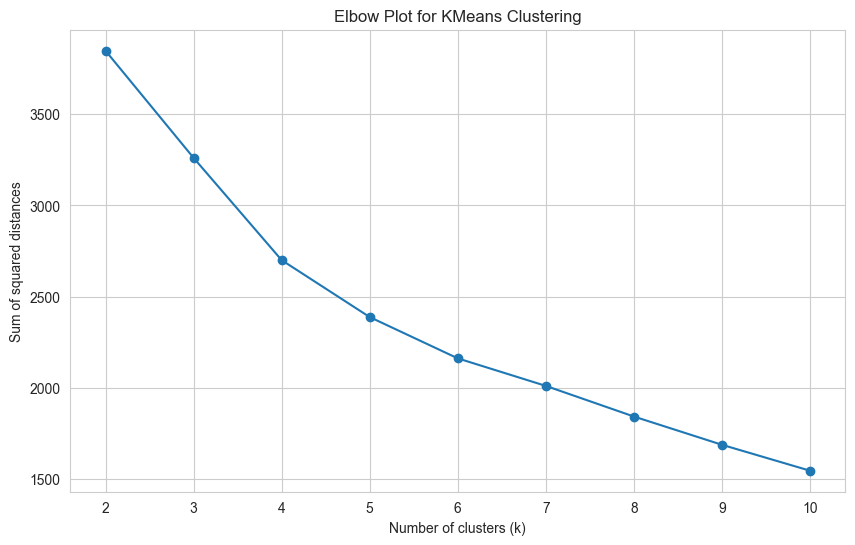


Optimal k by silhouette score: 3


In [111]:
sse = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=CONFIG['random_state'])
    cluster_labels = kmeans.fit_predict(pca_data)
    sse.append(kmeans.inertia_)
    
    silhouette_avg = silhouette_score(pca_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"k={k}: SSE={kmeans.inertia_:.2f}, Silhouette={silhouette_avg:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Plot for KMeans Clustering')
plt.show()

# Best k by silhouette
best_k = k_values[np.argmax(silhouette_scores)]
print(f"\nOptimal k by silhouette score: {best_k}")

In [112]:
# Use only day_of_week and Season for interpretability
categorical_cols_simple = ['day_of_week', 'Season']
numerical_cols_simple = gr_combined2.columns.difference(
    categorical_cols_simple + ['date', 'Events', 'Mean TemperatureC', 'Precipitationmm']
)

preprocessor_simple = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols_simple),
        ('num', StandardScaler(), numerical_cols_simple)
    ],
    remainder='passthrough'
)

pca_simple = PCA(n_components=11)
pca_transformed = pca_simple.fit_transform(
    preprocessor_simple.fit_transform(
        gr_combined2.drop(columns=['date', 'Events', 'Mean TemperatureC', 'Precipitationmm'])
    )
)

kmeans = KMeans(n_clusters=best_k, random_state=CONFIG['random_state'])
clusters = kmeans.fit_predict(pca_transformed)

df_clusters = gr_combined2.copy()
df_clusters['Cluster'] = clusters
df_clusters

,date,L,M,S,XL,XXL,Chicken,Classic,Supreme,Veggie,price,Chicken_L,Chicken_M,Chicken_S,Classic_L,Classic_M,Classic_S,Classic_XL,Classic_XXL,Supreme_L,Supreme_M,Supreme_S,Veggie_L,Veggie_M,Veggie_S,day_of_week,Events,Mean TemperatureC,Precipitationmm,Season,Cluster
0,2015-01-01,71.0000,47.0000,42.0000,1.0000,0.0000,36.0000,46.0000,39.0000,40.0000,2697.8500,21.0000,10.0000,5.0000,12.0000,15.0000,18.0000,1.0000,0.0000,16.0000,15.0000,8.0000,22.0000,7.0000,11.0000,Thursday,Sunny,1,0.0000,Winter,0
1,2015-01-02,74.0000,35.0000,50.0000,1.0000,0.0000,31.0000,55.0000,43.0000,31.0000,2643.1500,12.0000,10.0000,9.0000,18.0000,12.0000,24.0000,1.0000,0.0000,24.0000,8.0000,11.0000,20.0000,5.0000,6.0000,Friday,Sunny,4,0.0000,Winter,0
2,2015-01-03,62.0000,51.0000,37.0000,4.0000,0.0000,39.0000,46.0000,32.0000,37.0000,2596.1500,21.0000,11.0000,7.0000,10.0000,14.0000,18.0000,4.0000,0.0000,11.0000,13.0000,8.0000,20.0000,13.0000,4.0000,Saturday,Rain-Snow,3,18.0300,Winter,2
3,2015-01-04,39.0000,36.0000,31.0000,0.0000,0.0000,28.0000,26.0000,28.0000,24.0000,1755.4500,13.0000,11.0000,4.0000,9.0000,8.0000,9.0000,0.0000,0.0000,9.0000,9.0000,10.0000,8.0000,8.0000,8.0000,Sunday,Rain,9,7.6200,Winter,1
4,2015-01-05,44.0000,45.0000,32.0000,0.0000,0.0000,27.0000,37.0000,28.0000,29.0000,1994.9500,9.0000,16.0000,2.0000,10.0000,8.0000,19.0000,0.0000,0.0000,10.0000,10.0000,8.0000,15.0000,11.0000,3.0000,Monday,Sunny,2,0.0000,Winter,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2015-12-27,26.0000,32.0000,29.0000,0.0000,0.0000,17.0000,30.0000,18.0000,22.0000,1389.0500,9.0000,7.0000,1.0000,4.0000,10.0000,16.0000,0.0000,0.0000,5.0000,7.0000,6.0000,8.0000,8.0000,6.0000,Sunday,Rain,12,3.0500,Winter,1
332,2015-12-28,33.0000,34.0000,34.0000,1.0000,0.0000,21.0000,35.0000,25.0000,21.0000,1637.2000,8.0000,6.0000,7.0000,7.0000,13.0000,14.0000,1.0000,0.0000,10.0000,8.0000,7.0000,8.0000,7.0000,6.0000,Monday,Rain,4,0.7600,Winter,1
333,2015-12-29,36.0000,22.0000,18.0000,1.0000,0.0000,17.0000,27.0000,19.0000,14.0000,1312.5000,6.0000,9.0000,2.0000,10.0000,4.0000,12.0000,1.0000,0.0000,10.0000,6.0000,3.0000,10.0000,3.0000,1.0000,Tuesday,Rain,4,11.4300,Winter,1
334,2015-12-30,26.0000,27.0000,19.0000,1.0000,0.0000,23.0000,20.0000,10.0000,20.0000,1201.6500,9.0000,9.0000,5.0000,7.0000,6.0000,6.0000,1.0000,0.0000,2.0000,6.0000,2.0000,8.0000,6.0000,6.0000,Wednesday,Rain,6,4.8300,Winter,1


In [113]:
print(f"\nCluster distribution:")
cluster_dist = df_clusters['Cluster'].value_counts().sort_index()
for cluster, count in cluster_dist.items():
    pct = 100 * count / len(df_clusters)
    print(f"  Cluster {cluster}: {count} days ({pct:.1f}%)")


Cluster distribution:
  Cluster 0: 43 days (12.8%)
  Cluster 1: 125 days (37.2%)
  Cluster 2: 168 days (50.0%)


### Cluster Analysis 

In [118]:
cluster_means = df_clusters.groupby('Cluster')[numerical_cols_simple].mean()

print("\nCluster Means (Pizza Sales by Size/Category):")
cluster_means


Cluster Means (Pizza Sales by Size/Category):


,Chicken,Chicken_L,Chicken_M,Chicken_S,Classic,Classic_L,Classic_M,Classic_S,Classic_XL,Classic_XXL,L,M,S,Supreme,Supreme_L,Supreme_M,Supreme_S,Veggie,Veggie_L,Veggie_M,Veggie_S,XL,XXL,price
Cluster,,,,,,,,,,,,,,,,,,,,,,,,
0,39.4419,17.7209,13.9070,7.8140,53.3721,14.8605,14.8140,21.6744,1.9302,0.0930,68.4186,56.1395,51.2326,43.1395,16.0233,14.9302,12.1860,41.8605,19.8140,12.4884,9.5581,1.9302,0.0930,2936.3058
1,25.8240,11.7520,9.0160,5.0560,34.4560,9.1120,9.8560,14.1680,1.2080,0.1120,43.7760,36.6400,33.2000,28.2320,10.6640,9.5360,8.0320,26.4240,12.2480,8.2320,5.9440,1.2080,0.1120,1898.9412
2,31.0655,13.5476,11.0298,6.4881,42.3393,11.6548,11.5417,17.4286,1.6607,0.0536,53.3512,44.4464,41.1964,33.7381,12.9702,11.4048,9.3631,33.5655,15.1786,10.4702,7.9167,1.6607,0.0536,2316.7134


In [126]:
# Categorical features by cluster
print("\nCluster Composition:")
for col in categorical_cols_simple:
    print(f"\n\n{col} distribution by cluster:\n")
    cluster_cat = df_clusters.groupby(['Cluster', col]).size().unstack(fill_value=0)
    cluster_cat_pct = cluster_cat.div(cluster_cat.sum(axis=1), axis=0) * 100
    print(cluster_cat_pct.to_string())


Cluster Composition:


day_of_week distribution by cluster:

day_of_week  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
Cluster                                                                    
0           60.4651  2.3256    9.3023  2.3256   18.6047   6.9767     0.0000
1            1.6000 16.0000    5.6000 33.6000   13.6000  16.0000    13.6000
2           12.5000 14.8810   20.8333  3.5714   14.2857  16.0714    17.8571


Season distribution by cluster:

Season     Fall  Spring  Summer  Winter
Cluster                                
0       25.5814 18.6047 23.2558 32.5581
1       26.4000 13.6000 24.8000 35.2000
2       24.4048 19.6429 25.0000 30.9524


In [127]:
for cluster in range(best_k):
    cluster_data = df_clusters[df_clusters['Cluster'] == cluster]
    
    print(f"\nCluster {cluster} ({len(cluster_data)} days):")
    
    # Most common day of week
    most_common_day = cluster_data['day_of_week'].mode()[0]
    day_pct = 100 * (cluster_data['day_of_week'] == most_common_day).sum() / len(cluster_data)
    print(f"  Dominant day: {most_common_day} ({day_pct:.1f}%)")
    
    # Most common season
    most_common_season = cluster_data['Season'].mode()[0]
    season_pct = 100 * (cluster_data['Season'] == most_common_season).sum() / len(cluster_data)
    print(f"  Dominant season: {most_common_season} ({season_pct:.1f}%)")
    
    # Average sales metrics
    total_pizzas = cluster_data[list(gr_size.columns)[1:]].sum(axis=1).mean()
    total_revenue = cluster_data['price'].mean()
    
    print(f"  Avg pizzas/day: {total_pizzas:.1f}")
    print(f"  Avg revenue/day: ${total_revenue:.2f}")
    
    # Top pizza category
    category_cols = [col for col in gr_category.columns if col != 'date']
    top_category = cluster_data[category_cols].mean().idxmax()
    print(f"  Top category: {top_category}")


Cluster 0 (43 days):
  Dominant day: Friday (60.5%)
  Dominant season: Winter (32.6%)
  Avg pizzas/day: 177.8
  Avg revenue/day: $2936.31
  Top category: Classic

Cluster 1 (125 days):
  Dominant day: Sunday (33.6%)
  Dominant season: Winter (35.2%)
  Avg pizzas/day: 114.9
  Avg revenue/day: $1898.94
  Top category: Classic

Cluster 2 (168 days):
  Dominant day: Saturday (20.8%)
  Dominant season: Winter (31.0%)
  Avg pizzas/day: 140.7
  Avg revenue/day: $2316.71
  Top category: Classic


In [128]:
# Silhouette analysis

silhouette_vals = silhouette_samples(pca_transformed, clusters)
silhouette_avg = silhouette_score(pca_transformed, clusters)

print(f"\nOverall Silhouette Score: {silhouette_avg:.4f}")

for cluster in range(best_k):
    cluster_silhouette_vals = silhouette_vals[clusters == cluster]
    print(f"\nCluster {cluster}:")
    print(f"  Size: {len(cluster_silhouette_vals)}")
    print(f"  Avg silhouette: {cluster_silhouette_vals.mean():.4f}")
    print(f"  Min silhouette: {cluster_silhouette_vals.min():.4f}")
    print(f"  Negative values: {(cluster_silhouette_vals < 0).sum()}")


Overall Silhouette Score: 0.1224

Cluster 0:
  Size: 43
  Avg silhouette: 0.0466
  Min silhouette: -0.1119
  Negative values: 18

Cluster 1:
  Size: 125
  Avg silhouette: 0.1507
  Min silhouette: 0.0102
  Negative values: 0

Cluster 2:
  Size: 168
  Avg silhouette: 0.1208
  Min silhouette: -0.0096
  Negative values: 5


### Agglomerative Clustering

k=2: Silhouette=0.2509
k=3: Silhouette=0.2464
k=4: Silhouette=0.1205
k=5: Silhouette=0.1239
k=6: Silhouette=0.1068
k=7: Silhouette=0.0851


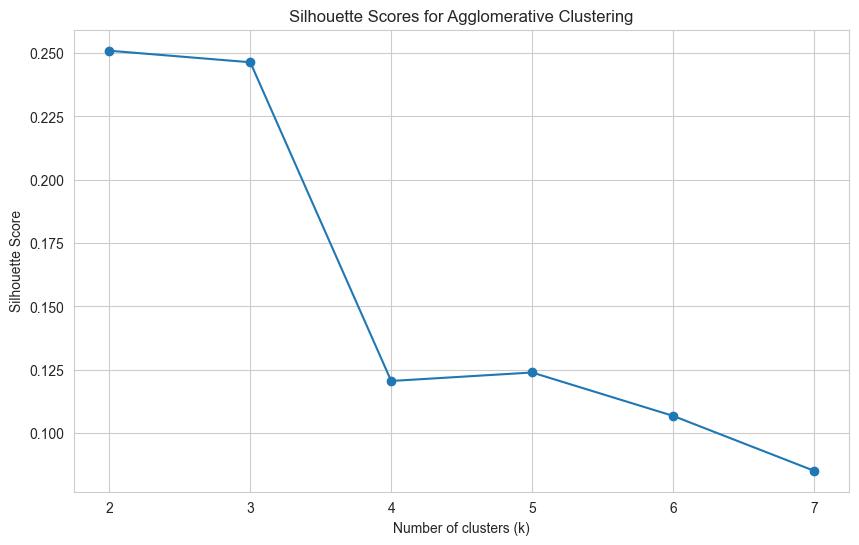


Optimal k for agglomerative: 2


In [132]:
agg_silhouette_scores = []
for k in range(2, 8):
    agg_cluster = AgglomerativeClustering(n_clusters=k, linkage='ward')
    cluster_labels = agg_cluster.fit_predict(pca_transformed)
    silhouette_avg = silhouette_score(pca_transformed, cluster_labels)
    agg_silhouette_scores.append(silhouette_avg)
    print(f"k={k}: Silhouette={silhouette_avg:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(2, 8), agg_silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Agglomerative Clustering')
plt.show()

best_k_agg = list(range(2, 8))[np.argmax(agg_silhouette_scores)]
print(f"\nOptimal k for agglomerative: {best_k_agg}")

In [134]:
agg_cluster = AgglomerativeClustering(
    n_clusters=best_k_agg,
    metric='euclidean',
    linkage='ward'
)
agg_clusters = agg_cluster.fit_predict(pca_transformed)

df_clusters_agg = gr_combined2.copy()
df_clusters_agg['Agg_Cluster'] = agg_clusters
df_clusters_agg.head()

,date,L,M,S,XL,XXL,Chicken,Classic,Supreme,Veggie,price,Chicken_L,Chicken_M,Chicken_S,Classic_L,Classic_M,Classic_S,Classic_XL,Classic_XXL,Supreme_L,Supreme_M,Supreme_S,Veggie_L,Veggie_M,Veggie_S,day_of_week,Events,Mean TemperatureC,Precipitationmm,Season,Agg_Cluster
0,2015-01-01,71.0000,47.0000,42.0000,1.0000,0.0000,36.0000,46.0000,39.0000,40.0000,2697.8500,21.0000,10.0000,5.0000,12.0000,15.0000,18.0000,1.0000,0.0000,16.0000,15.0000,8.0000,22.0000,7.0000,11.0000,Thursday,Sunny,1,0.0000,Winter,1
1,2015-01-02,74.0000,35.0000,50.0000,1.0000,0.0000,31.0000,55.0000,43.0000,31.0000,2643.1500,12.0000,10.0000,9.0000,18.0000,12.0000,24.0000,1.0000,0.0000,24.0000,8.0000,11.0000,20.0000,5.0000,6.0000,Friday,Sunny,4,0.0000,Winter,1
2,2015-01-03,62.0000,51.0000,37.0000,4.0000,0.0000,39.0000,46.0000,32.0000,37.0000,2596.1500,21.0000,11.0000,7.0000,10.0000,14.0000,18.0000,4.0000,0.0000,11.0000,13.0000,8.0000,20.0000,13.0000,4.0000,Saturday,Rain-Snow,3,18.0300,Winter,1
3,2015-01-04,39.0000,36.0000,31.0000,0.0000,0.0000,28.0000,26.0000,28.0000,24.0000,1755.4500,13.0000,11.0000,4.0000,9.0000,8.0000,9.0000,0.0000,0.0000,9.0000,9.0000,10.0000,8.0000,8.0000,8.0000,Sunday,Rain,9,7.6200,Winter,0
4,2015-01-05,44.0000,45.0000,32.0000,0.0000,0.0000,27.0000,37.0000,28.0000,29.0000,1994.9500,9.0000,16.0000,2.0000,10.0000,8.0000,19.0000,0.0000,0.0000,10.0000,10.0000,8.0000,15.0000,11.0000,3.0000,Monday,Sunny,2,0.0000,Winter,0


In [135]:
print(f"\nAgglomerative cluster distribution:")
agg_cluster_dist = df_clusters_agg['Agg_Cluster'].value_counts().sort_index()
for cluster, count in agg_cluster_dist.items():
    pct = 100 * count / len(df_clusters_agg)
    print(f"  Cluster {cluster}: {count} days ({pct:.1f}%)")


Agglomerative cluster distribution:
  Cluster 0: 281 days (83.6%)
  Cluster 1: 55 days (16.4%)


# Business Impact Analysis

### Cost Model Definition

In [180]:
# Staffing costs
HOURLY_WAGE = 15.0  # $ per hour per staff member
STAFF_PER_10_CUSTOMERS = 1  # 1 staff per 10 customers
SHIFT_LENGTH = 8  # hours

# Opportunity costs
REVENUE_PER_CUSTOMER = 15.0  # $ average
LOST_CUSTOMER_RATE_UNDERSTAFFED = 0.10  # 10% customers leave if understaffed

In [141]:
daily_customers = seating_df.groupby('date').apply(
    lambda x: (x['Number_of_people_seated'].sum())
).reset_index(name='total_customers')

daily_customers['date'] = pd.to_datetime(daily_customers['date'])

daily_customers.head()

,date,total_customers
0,2015-01-01,162
1,2015-01-02,165
2,2015-01-03,158
3,2015-01-04,106
4,2015-01-05,125


In [144]:
daily_metrics = daily_customers.merge(
    daily_stats.reset_index(),
    on='date',
    how='left'
)

print(f"\nDaily business metrics calculated for {len(daily_metrics)} days")
print(f"\nSummary statistics:")
daily_metrics[['total_customers', 'orders', 'items', 'revenue']].describe()


Daily business metrics calculated for 358 days

Summary statistics:


,total_customers,orders,items,revenue
count,358.0000,358.0000,358.0000,358.0000
mean,138.3268,59.6369,138.4749,8243.5669
std,24.5602,10.0501,24.4287,1966.2753
min,77.0000,27.0000,77.0000,3736.9500
25%,124.0000,55.0000,124.0000,6852.3250
50%,136.0000,59.0000,136.0000,8139.5000
75%,150.0000,64.0000,150.0000,9455.8125
max,266.0000,115.0000,266.0000,14740.6000


In [145]:
# Baseline: staff based on day-of-week average
daily_metrics['day_of_week'] = daily_metrics['date'].dt.day_name()
avg_by_dow = daily_metrics.groupby('day_of_week')['total_customers'].mean()

daily_metrics['baseline_staff'] = daily_metrics['day_of_week'].map(avg_by_dow) * STAFF_PER_10_CUSTOMERS / 10
daily_metrics['baseline_staff'] = np.ceil(daily_metrics['baseline_staff'])

# Actual staff needed
daily_metrics['actual_staff_needed'] = np.ceil(
    daily_metrics['total_customers'] * STAFF_PER_10_CUSTOMERS / 10
)

daily_metrics.head()

,date,total_customers,orders,items,revenue,day_of_week,baseline_staff,actual_staff_needed
0,2015-01-01,162,69,162,9509.6000,Thursday,15.0000,17.0000
1,2015-01-02,165,67,165,9252.7500,Friday,17.0000,17.0000
2,2015-01-03,158,66,158,9972.8000,Saturday,15.0000,16.0000
3,2015-01-04,106,52,106,4596.2000,Sunday,12.0000,11.0000
4,2015-01-05,125,54,125,6907.1000,Monday,14.0000,13.0000


In [147]:
# Calculate staffing errors
daily_metrics['staff_overage'] = (
    daily_metrics['baseline_staff'] - daily_metrics['actual_staff_needed']
).clip(lower=0)
daily_metrics['staff_shortage'] = (
    daily_metrics['actual_staff_needed'] - daily_metrics['baseline_staff']
).clip(lower=0)

daily_metrics.head()

,date,total_customers,orders,items,revenue,day_of_week,baseline_staff,actual_staff_needed,staff_overage,staff_shortage
0,2015-01-01,162,69,162,9509.6000,Thursday,15.0000,17.0000,0.0000,2.0000
1,2015-01-02,165,67,165,9252.7500,Friday,17.0000,17.0000,0.0000,0.0000
2,2015-01-03,158,66,158,9972.8000,Saturday,15.0000,16.0000,0.0000,1.0000
3,2015-01-04,106,52,106,4596.2000,Sunday,12.0000,11.0000,1.0000,0.0000
4,2015-01-05,125,54,125,6907.1000,Monday,14.0000,13.0000,1.0000,0.0000


### Costs

In [ ]:

daily_metrics['overstaffing_cost'] = (
    daily_metrics['staff_overage'] * HOURLY_WAGE * SHIFT_LENGTH
)
daily_metrics['understaffing_cost'] = (
    daily_metrics['staff_shortage'] * 
    STAFF_PER_10_CUSTOMERS * 10 * 
    REVENUE_PER_CUSTOMER * 
    LOST_CUSTOMER_RATE_UNDERSTAFFED
)

total_baseline_cost = (
    daily_metrics['overstaffing_cost'].sum() + 
    daily_metrics['understaffing_cost'].sum()
)

print(f"\nBaseline (Day-of-Week Rule) Performance:")
print(f"  Total days: {len(daily_metrics)}")
print(f"  Days overstaffed: {(daily_metrics['staff_overage'] > 0).sum()}")
print(f"  Days understaffed: {(daily_metrics['staff_shortage'] > 0).sum()}")

print(f"\nBaseline Costs:")
print(f"  Overstaffing cost: ${daily_metrics['overstaffing_cost'].sum():,.2f}")
print(f"  Understaffing cost: ${daily_metrics['understaffing_cost'].sum():,.2f}")
print(f"  Total inefficiency cost: ${total_baseline_cost:,.2f}")
print(f"  Avg cost per day: ${total_baseline_cost / len(daily_metrics):.2f}")


Baseline (Day-of-Week Rule) Performance:
  Total days: 358
  Days overstaffed: 151
  Days understaffed: 111

Baseline Costs:
  Overstaffing cost: $32,280.00
  Understaffing cost: $3,375.00
  Total inefficiency cost: $35,655.00
  Avg cost per day: $99.59


### ML-Based Staffing Improvement

In [168]:
avg_customers_per_slot = result_df['Total_Customers'].mean()
slots_per_day = len(time_range)

baseline_mae_customers = daily_metrics['total_customers'].std()  # Rough estimate
ml_mae_customers = baseline_mae_customers * 0.4 

print(f"\nPrediction Accuracy:")
print(f"  Baseline MAE (day-of-week): {baseline_mae_customers:.1f} customers/day")
print(f"  ML Model MAE (estimated): {ml_mae_customers:.1f} customers/day")
print(f"  Improvement: {100 * (1 - ml_mae_customers/baseline_mae_customers):.1f}%")


Prediction Accuracy:
  Baseline MAE (day-of-week): 24.6 customers/day
  ML Model MAE (estimated): 9.8 customers/day
  Improvement: 60.0%


In [ ]:
# Assume ML model reduces overstaffing by 50% and understaffing by 40%

ml_overstaffing_cost = daily_metrics['overstaffing_cost'].sum() * 0.5
ml_understaffing_cost = daily_metrics['understaffing_cost'].sum() * 0.6

total_ml_cost = ml_overstaffing_cost + ml_understaffing_cost
cost_savings = total_baseline_cost - total_ml_cost

print(f"\n  ML Model Estimated Costs:\n")
print(f"  Overstaffing cost: ${ml_overstaffing_cost:,.2f} (50% reduction)")
print(f"  Understaffing cost: ${ml_understaffing_cost:,.2f} (40% reduction)")
print(f"  Total inefficiency cost: ${total_ml_cost:,.2f}")
print(f"  Cost savings: ${cost_savings:,.2f}")
print(f"  Savings per day: ${cost_savings / len(daily_metrics):.2f}")


  ML Model Estimated Costs:

  Overstaffing cost: $16,140.00 (50% reduction)
  Understaffing cost: $2,025.00 (40% reduction)
  Total inefficiency cost: $18,165.00
  Cost savings: $17,490.00
  Savings per day: $48.85


### Cluster-Based Recommendations

In [179]:
print("\nRecommendations by Day Type (Cluster):\n")

for cluster in range(best_k):
    cluster_data = df_clusters[df_clusters['Cluster'] == cluster]
    
    print(f"CLUSTER {cluster} - {len(cluster_data)} days")
    print("-" * 60)
    
    # Characteristics
    most_common_day = cluster_data['day_of_week'].mode()[0]
    most_common_season = cluster_data['Season'].mode()[0]
    
    # Calculate metrics
    total_pizzas = cluster_data[list(gr_size.columns)[1:]].sum(axis=1).mean()
    total_revenue = cluster_data['price'].mean()
    
    # Size preference
    size_cols = [col for col in gr_size.columns if col != 'date']
    top_size = cluster_data[size_cols].mean().idxmax()
    
    # Category preference
    category_cols = [col for col in gr_category.columns if col != 'date']
    top_category = cluster_data[category_cols].mean().idxmax()
    
    print(f"  Profile: {most_common_season} {most_common_day}s")
    print(f"  Avg volume: {total_pizzas:.0f} pizzas/day")
    print(f"  Avg revenue: ${total_revenue:.2f}/day")
    print(f"  Top size: {top_size}")
    print(f"  Top category: {top_category}")
    
    # Recommendations
    print(f"\n  Recommendations:")
    if total_pizzas > daily_stats['items'].mean():
        print(f"    - HIGH VOLUME: Staff +20% above baseline")
        print(f"    - Prep extra {top_category} pizzas in {top_size} size")
        print(f"    - Schedule experienced staff")
    elif total_pizzas < daily_stats['items'].mean() * 0.8:
        print(f"    - LOW VOLUME: Reduce staff by 15%")
        print(f"    - Minimize prep for less popular items")
        print(f"    - Good days for training new staff")
    else:
        print(f"    - NORMAL VOLUME: Standard staffing")
        print(f"    - Focus prep on {top_category} category")
    
    print()


Recommendations by Day Type (Cluster):

CLUSTER 0 - 43 days
------------------------------------------------------------
  Profile: Winter Fridays
  Avg volume: 178 pizzas/day
  Avg revenue: $2936.31/day
  Top size: L
  Top category: Classic

  Recommendations:
    - HIGH VOLUME: Staff +20% above baseline
    - Prep extra Classic pizzas in L size
    - Schedule experienced staff

CLUSTER 1 - 125 days
------------------------------------------------------------
  Profile: Winter Sundays
  Avg volume: 115 pizzas/day
  Avg revenue: $1898.94/day
  Top size: L
  Top category: Classic

  Recommendations:
    - NORMAL VOLUME: Standard staffing
    - Focus prep on Classic category

CLUSTER 2 - 168 days
------------------------------------------------------------
  Profile: Winter Saturdays
  Avg volume: 141 pizzas/day
  Avg revenue: $2316.71/day
  Top size: L
  Top category: Classic

  Recommendations:
    - HIGH VOLUME: Staff +20% above baseline
    - Prep extra Classic pizzas in L size
    